In [1]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import numpy as np
import matplotlib.cm as cm
import itertools
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt

### Get performance and plotting

This script investigate what genes can/not be transferred well from RPE1 to K562. Specifically, it would create a dot plot such that each perturbation is a dot and 

x-axis: prediction performance of the fine-tuning on ctrl model (MMD)

y-axis: cell line disagreement (Euclidean distance)

In [2]:
# load in data
cl_train_dataset = 'transfer_cell_line_rpe1_train'
cl_test_dataset = 'transfer_cell_line_k562_essential_test'
use_hvg = True
cl_train_dataset_name = cl_train_dataset + ('_hvg' if use_hvg else '_full')
cl_test_dataset_name = cl_test_dataset + ('_hvg' if use_hvg else '_full')

recon_loss = 'mmd'
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
tolerance_epoch = 20
mxAlpha = 2.0
n_epochs = 100
latdim_ctrl = 50
latdim_ptb = 50
geneset_num = 50
validation_set_ratio = 0.1
validation_ood_ratio = 0.15
prior = 'DepMap_GeneEffect'
model_type = 'mvae_attention_vae_14_3'
look_at = 'mean_delta' # mean_delta or mean

In [3]:
random_seeds = [8, 9, 10, 11, 12]
# random_seeds = [12] # same random seed as those in 5-fold cross-validation

In [4]:
import os
savedir = (f'{cl_train_dataset_name}/{cl_test_dataset_name}/'
           f'latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}/null_label_{null_label}/'
           f'tolerance_epochs_{tolerance_epoch}/val_{validation_set_ratio}_ood_{validation_ood_ratio}')

if not os.path.exists(savedir):
    os.makedirs(savedir)

### Step 1.0 Read in transfer results (fine-tune on control)

In [5]:
ft_train_path = f'/home/che/perturb-project/predict_model/result/rna/{cl_train_dataset_name}/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}/transfer_cell_line'
ft_ctrl_df = pd.DataFrame()
for seed in random_seeds:
    # load in fine-tune on control results
    ft_path_temp = (f'{ft_train_path}/recon_loss_{recon_loss}/null_label_{null_label}/epochs_{n_epochs}/'
                    f'tolerance_epochs_{tolerance_epoch}/mxAlpha_{mxAlpha}/'
                    f'val_{validation_set_ratio}_ood_{validation_ood_ratio}/random_seed_12')
    pattern = f'{ft_path_temp}/{prior}_{model_type}_run*'
    ft_path_temp = glob.glob(pattern)
    assert len(ft_path_temp) == 1, f'Error: {pattern}'
    ft_path_temp = ft_path_temp[0]
    ft_ctrl_path_temp = f'{ft_path_temp}/ctrl_ft/best_model_ctrl_ft_epochs_9_rand_seed_{seed}_results.csv'
    ft_ctrl_df_temp = pd.read_csv(ft_ctrl_path_temp)
    ft_ctrl_df_temp['random_seed'] = seed
    ft_ctrl_df_temp['model_type'] = 'Fine-tune on control'
    ft_ctrl_df_temp['model_path'] = ft_ctrl_path_temp
    ft_ctrl_df = pd.concat([ft_ctrl_df, ft_ctrl_df_temp])

In [6]:
# calcualte mean of mmd for each pert
ft_ctrl_df = ft_ctrl_df.groupby("pert").agg(
    mmd_mean=("mmd", "mean"),
    mmd_std=("mmd", "std")
).reset_index()

ft_ctrl_df.rename(columns={'mmd_mean': 'mmd_mean_ft_ctrl', 'mmd_std': 'mmd_std_ft_ctrl'}, inplace=True)
ft_ctrl_df

,pert,mmd_mean_ft_ctrl,mmd_std_ft_ctrl
0,AAAS,0.199671,0.011287
1,AARS,1.294535,0.172240
2,AARS2,0.395860,0.022079
3,AASDHPPT,0.398643,0.074665
4,AATF,0.998811,0.063467
...,...,...,...
1889,ZNRD1,1.000385,0.078805
1890,ZRANB2,0.644308,0.116436
1891,ZRSR2,0.349514,0.020691
1892,ZW10,0.230787,0.014611


### Step 1.1 Read in cell line agreement

In [8]:
cell_line_agreement_path = f'train_{cl_train_dataset_name}_test_{cl_test_dataset_name}_agreement/agreement_{look_at}.csv'
cell_line_agreement_df = pd.read_csv(cell_line_agreement_path)
cell_line_agreement_df

,perturbation,euclidean_distance
0,AAAS,3.540442
1,AARS,13.005581
2,AARS2,3.987233
3,AASDHPPT,5.788666
4,AATF,13.147428
...,...,...
1928,ZNRD1,12.780866
1929,ZRANB2,5.806083
1930,ZRSR2,4.794155
1931,ZW10,6.774330


### Step 1.2 Merge two data frames together

In [9]:
eval_df = pd.merge(ft_ctrl_df, cell_line_agreement_df, left_on='pert', right_on='perturbation', how='inner')
eval_df

,pert,mmd_mean_ft_ctrl,mmd_std_ft_ctrl,perturbation,euclidean_distance
0,AAAS,0.199671,0.011287,AAAS,3.540442
1,AARS,1.294535,0.172240,AARS,13.005581
2,AARS2,0.395860,0.022079,AARS2,3.987233
3,AASDHPPT,0.398643,0.074665,AASDHPPT,5.788666
4,AATF,0.998811,0.063467,AATF,13.147428
...,...,...,...,...,...
1889,ZNRD1,1.000385,0.078805,ZNRD1,12.780866
1890,ZRANB2,0.644308,0.116436,ZRANB2,5.806083
1891,ZRSR2,0.349514,0.020691,ZRSR2,4.794155
1892,ZW10,0.230787,0.014611,ZW10,6.774330


In [11]:
# save eval_df into csv file
eval_df.to_csv(f'{savedir}/plot_df.csv', index=False)

### Step 1. Draw a dot plot to compare mmd_mean_ft_ctrl and mmd_mean_ft_ctrl

In [13]:
from scipy.stats import pearsonr
x = eval_df['mmd_mean_ft_ctrl']
y = eval_df['euclidean_distance']
pearson_corr, p_value = pearsonr(x, y)
print(f"Pearson Correlation: {pearson_corr:.2f}, P-value: {p_value:.2e}")

Pearson Correlation: 0.52, P-value: 5.46e-131


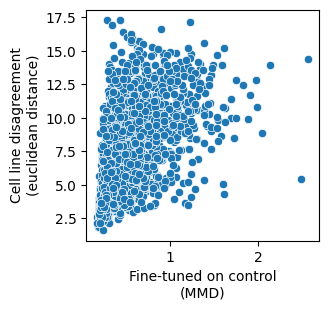

In [15]:
# create a dot plot so that mmd_mean_ft_ctrl is on x-axis and mmd_mean_train_large is on y-axis
plt.figure(figsize=(3, 3))
sns.scatterplot(data=eval_df, 
                x='mmd_mean_ft_ctrl', 
                y='euclidean_distance')
plt.xlabel('Fine-tuned on control\n(MMD)')
plt.ylabel('Cell line disagreement\n(euclidean distance)')
plt.show()

### Step 2. Get the annotated gene sets and try coloring the plots by gene sets

In [16]:
gene_set_df_path = '/home/che/perturb-project/git/gene_ptb_prediction/grn/gene_clusters/replogle/perturbation_clusters.csv'
gene_set_df = pd.read_csv(gene_set_df_path)
gene_set_df = gene_set_df[['members', 'best_description']]
gene_set_df.columns = ['pert', 'gene_set']
gene_set_df.head()

,pert,gene_set
0,AMMECR1,unknown 1
1,RAB4B,unknown 1
2,RNF11,unknown 1
3,SH3GL1,unknown 1
4,ZNF326,unknown 2


In [17]:
gene_set_df['gene_set'].unique()

array(['unknown 1', 'unknown 2', 'unknown 3', 'unknown 4',
       'm6A mRNA methylation', 'nonsense-mediated decay',
       'histone acetylation 1', 'INO80 complex',
       'exosome and mRNA turnover', 'post-translational modifications 1',
       'post-translational modifications 2',
       'post-translational modifications 3', 'unknown 5',
       'Chaperonin TCP-1', 'Paf complex', 'FACT complex',
       'Ragulator complex', 'post-translational modifications 4',
       'COP9 signalosome', 'unknown 6', 'unknown 7',
       'activation of splicing', 'Integrator complex 1', 'unknown 8',
       'pyrimidine biosynthesis/mitochondrial complex II',
       'nuclear export', 'mRNA polyadenylation', 'chromosome segregation',
       'NELF complex', 'histone acetylation 2', 'tRNA modification',
       'spliceosome', 'microRNA biogenesis', 'vesicular trafficking',
       'unknown 9', 'unknown 10', 'Integrator complex 2', 'TFIID complex',
       'unknown 11', 'EIF3 1/Ku antigen complex', 'ESCRT compl

In [18]:
plot_df = pd.merge(eval_df, gene_set_df, on='pert', how='left')
# if gene_set is 'unknown1', set to np.nan
plot_df['gene_set'] = plot_df['gene_set'].apply(lambda x: np.nan if x in ['unknown 1', 'unknown 2', 'unknown 3', 'unknown 4', 'unknown 5', 'unknown 6', 'unknown 7', 'unknown 8', 'unknown 10', 'unknown 12'] else x)

In [19]:
group_mmd = plot_df.groupby('gene_set')['mmd_mean_ft_ctrl'].mean()
group_mmd = (group_mmd - group_mmd.min()) / (group_mmd.max() - group_mmd.min())
group_mmd = pd.DataFrame(group_mmd).reset_index()
group_mmd.head()

,gene_set,mmd_mean_ft_ctrl
0,"28S ribosomal subunit, mitochondrial",0.254526
1,"39S ribosomal subunit, mitochondrial",0.212074
2,"40S ribosomal subunit, cytoplasmic",0.561806
3,"60S ribosomal subunit, cytoplasmic",0.417410
4,BCR-ABL signaling,0.611449


In [20]:
group_euclidean = plot_df.groupby('gene_set')['euclidean_distance'].mean()
group_euclidean = (group_euclidean - group_euclidean.min()) / (group_euclidean.max() - group_euclidean.min())
group_euclidean = pd.DataFrame(group_euclidean).reset_index()
group_euclidean.head()

,gene_set,euclidean_distance
0,"28S ribosomal subunit, mitochondrial",0.009810
1,"39S ribosomal subunit, mitochondrial",0.055779
2,"40S ribosomal subunit, cytoplasmic",0.919197
3,"60S ribosomal subunit, cytoplasmic",0.860941
4,BCR-ABL signaling,0.247179


In [21]:
group_all = pd.merge(group_mmd, group_euclidean, on='gene_set', how='outer')
group_all['total_score'] = group_all['mmd_mean_ft_ctrl'] + group_all['euclidean_distance']
group_all.sort_values('total_score', ascending=False).head(5)

,gene_set,mmd_mean_ft_ctrl,euclidean_distance,total_score
27,erythroid differentiation,0.950326,0.761091,1.711417
28,exosome and mRNA turnover,1.000000,0.691492,1.691492
12,FACT complex,0.628734,0.874783,1.503517
2,"40S ribosomal subunit, cytoplasmic",0.561806,0.919197,1.481003
16,Mediator complex,0.615993,0.801889,1.417883


In [22]:
group_all.sort_values('total_score', ascending=True).head(5)

,gene_set,mmd_mean_ft_ctrl,euclidean_distance,total_score
43,post-translational modifications 2,0.000000,0.000000,0.000000
37,microRNA biogenesis,0.036800,0.097769,0.134569
15,Integrator complex 2,0.146844,0.112694,0.259538
0,"28S ribosomal subunit, mitochondrial",0.254526,0.009810,0.264336
1,"39S ribosomal subunit, mitochondrial",0.212074,0.055779,0.267853


In [23]:
custom_color = {
    'erythroid differentiation': '#ff0000',
    'exosome and mRNA turnover': '#ff992b',
    'FACT complex': '#ffdd0b',
    '40S ribosomal subunit, cytoplasmic': '#fba2ac',
    'Mediator complex': '#ffe4e9',

    'post-translational modifications 2': '#2d6a4f', #'#87cefa',
    'microRNA biogenesis': '#8ecc7a', #'#7bc043',
    'Integrator complex 2': '#3dc6c3', #'#0392cf',
    '28S ribosomal subunit, mitochondrial': '#3d85c6', #'#36abb5',
    '39S ribosomal subunit, mitochondrial': '#99b3ff', #'#f37736',
    'Others': 'lightgrey'
}

desired_order = list(custom_color.keys())
desired_order

plot_df['selected_gene_set'] = plot_df['gene_set'].apply(lambda x: x if x in desired_order else 'Others')

x = eval_df['mmd_mean_ft_ctrl']
y = eval_df['euclidean_distance']
pearson_corr, p_value = pearsonr(x, y)
print(f"Pearson Correlation: {pearson_corr:.2f}, P-value: {p_value:.2e}")

Pearson Correlation: 0.52, P-value: 5.46e-131


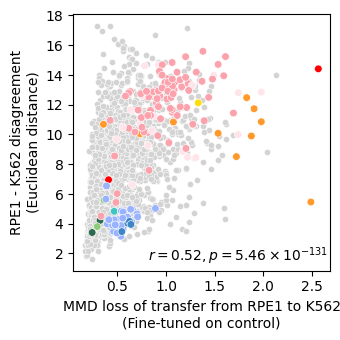

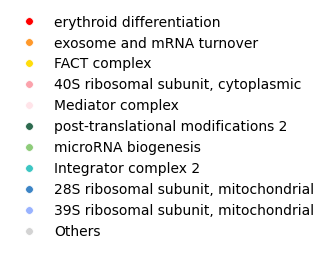

In [25]:
# Separate the data into "Others" and the rest
others_df = plot_df[plot_df['selected_gene_set'] == 'Others']
colored_df = plot_df[plot_df['selected_gene_set'] != 'Others']

# Create the scatter plot
plt.figure(figsize=(3.5, 3.5))

# Plot "Others" first with a lower z-order (background)
sns.scatterplot(
    data=others_df, 
    x='mmd_mean_ft_ctrl', 
    y='euclidean_distance',
    color=custom_color['Others'],  # Adjust color for "Others"
    label='',
    s=20,  # Adjust marker size for visibility
    zorder=1  # Lower z-order to place it in the background
)

# Plot the other categories on top
scatter = sns.scatterplot(
    data=colored_df, 
    x='mmd_mean_ft_ctrl', 
    y='euclidean_distance',
    hue='selected_gene_set',
    hue_order=desired_order,
    palette=custom_color,
    s=30,  # Larger marker size for emphasis
    zorder=2  # Higher z-order to place on top
)

# Annotation
formatted_p_value = f"{p_value:.2e}"  # Convert to scientific notation
base, exponent = formatted_p_value.split('e')  # Split the base and exponent
formatted_p_value_latex = f"{float(base):.2f} \\times 10^{{{int(exponent)}}}"
plt.text(
    0.29, 0.1,
    rf"$r={pearson_corr:.2f},p={formatted_p_value_latex}$",
    transform=plt.gca().transAxes,  # Use axes coordinates for positioning
    fontsize=10,
    verticalalignment='top'
)

# Adjust labels
plt.xlabel('MMD loss of transfer from RPE1 to K562\n(Fine-tuned on control)')
plt.ylabel('RPE1 - K562 disagreement\n(Euclidean distance)')

# Extract the legend
legend = scatter.legend(
    bbox_to_anchor=(1, 0.5),  # Adjust the position as needed
    loc='center left',
    fontsize=10,
    frameon=False
)

# Remove the legend from the main plot
scatter.legend_.remove()

# Save the scatter plot
plt.tight_layout()
plt.savefig(f'{savedir}/scatter_plot.png', dpi=300)
plt.savefig(f'{savedir}/scatter_plot.svg', format='svg')
plt.show()
plt.close()

# Create a blank plot to save the legend
fig_legend = plt.figure(figsize=(4, 3))  # Adjust size for the legend
ax_legend = fig_legend.add_subplot(111)
ax_legend.axis('off')
ax_legend.legend(
    handles=legend.legendHandles, 
    labels=[t.get_text() for t in legend.get_texts()],
    loc='center',
    fontsize=10,
    frameon=False
)

# Save the legend plot
fig_legend.savefig(f'{savedir}/legend_plot.png', dpi=300)
fig_legend.savefig(f'{savedir}/legend_plot.svg', format='svg')
plt.show()
plt.close(fig_legend)

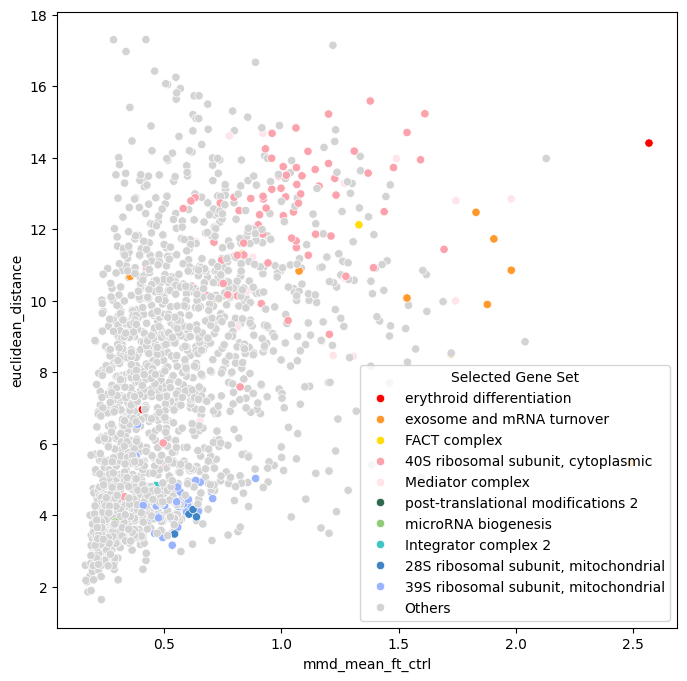

In [26]:
plt.figure(figsize=(8, 8))

# Plot the colored dots on top
sns.scatterplot(
    data=plot_df, 
    x='mmd_mean_ft_ctrl', 
    y='euclidean_distance',
    hue='selected_gene_set',
    hue_order=desired_order,
    palette=custom_color,
    alpha=1  # Full alpha for colored dots
)

plt.legend(title='Selected Gene Set')  # Add legend only for the colored dots
plt.show()

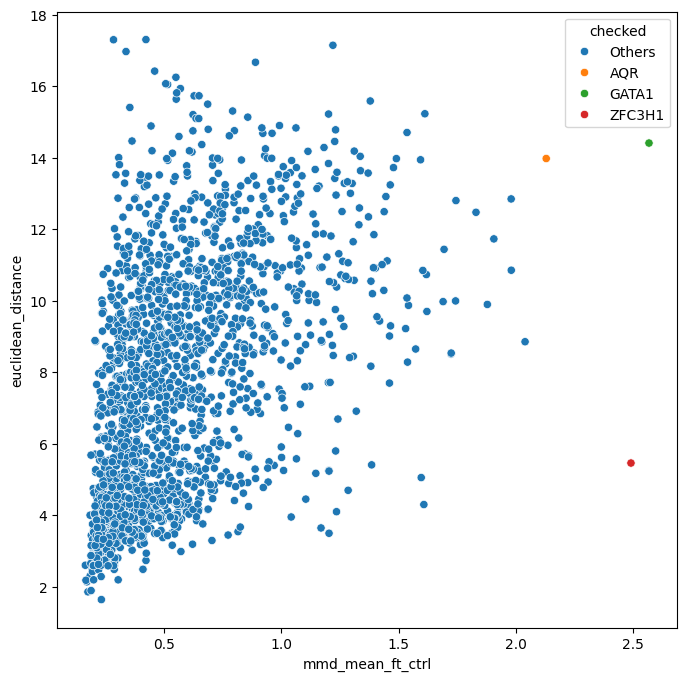

In [27]:
checked_genes = plot_df.sort_values('mmd_mean_ft_ctrl', ascending=False).head(3)['pert'].values.tolist()
plot_df['checked'] = plot_df['pert'].apply(lambda x: x if x in checked_genes else 'Others')

plt.figure(figsize=(8, 8))

# Plot the colored dots on top
sns.scatterplot(
    data=plot_df, 
    x='mmd_mean_ft_ctrl', 
    y='euclidean_distance',
    hue='checked'
)
plt.show()